nodes:  50 links  69


/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huang/anaconda3/envs/gt/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min 
0  	300   	8902
1  	183   	8902
2  	185   	8902
3  	200   	8902
4  	168   	8902
5  	165   	8872
6  	194   	8802
7  	180   	8802
8  	180   	8802
9  	178   	8800
10 	172   	8800
11 	170   	8728
12 	174   	8728
13 	172   	8680
14 	178   	8680
15 	185   	8668
16 	182   	8648
17 	177   	8648
18 	169   	8584
19 	180   	8562
20 	173   	8494
21 	159   	8542
22 	186   	8470
23 	181   	8470
24 	162   	8470
25 	183   	8412
26 	176   	8412
27 	175   	8442
28 	165   	8402
29 	167   	8362
30 	160   	8362
31 	178   	8262
32 	175   	8262
33 	183   	8262
34 	190   	8262
35 	189   	8222
36 	172   	8138
37 	175   	8138
38 	179   	8138
39 	182   	8120
40 	188   	8120
41 	174   	8086
42 	187   	8086
43 	187   	8086
44 	177   	8010
45 	180   	8018
46 	193   	7990
47 	191   	7990
48 	176   	7990
49 	180   	7968
50 	179   	7934
51 	189   	7916
52 	171   	7924
53 	179   	7934
54 	182   	7904
55 	178   	7864
56 	187   	7838
57 	181   	7838
58 	185   	7784
59 	173   	7784
60 	165   	7768
61 	180 

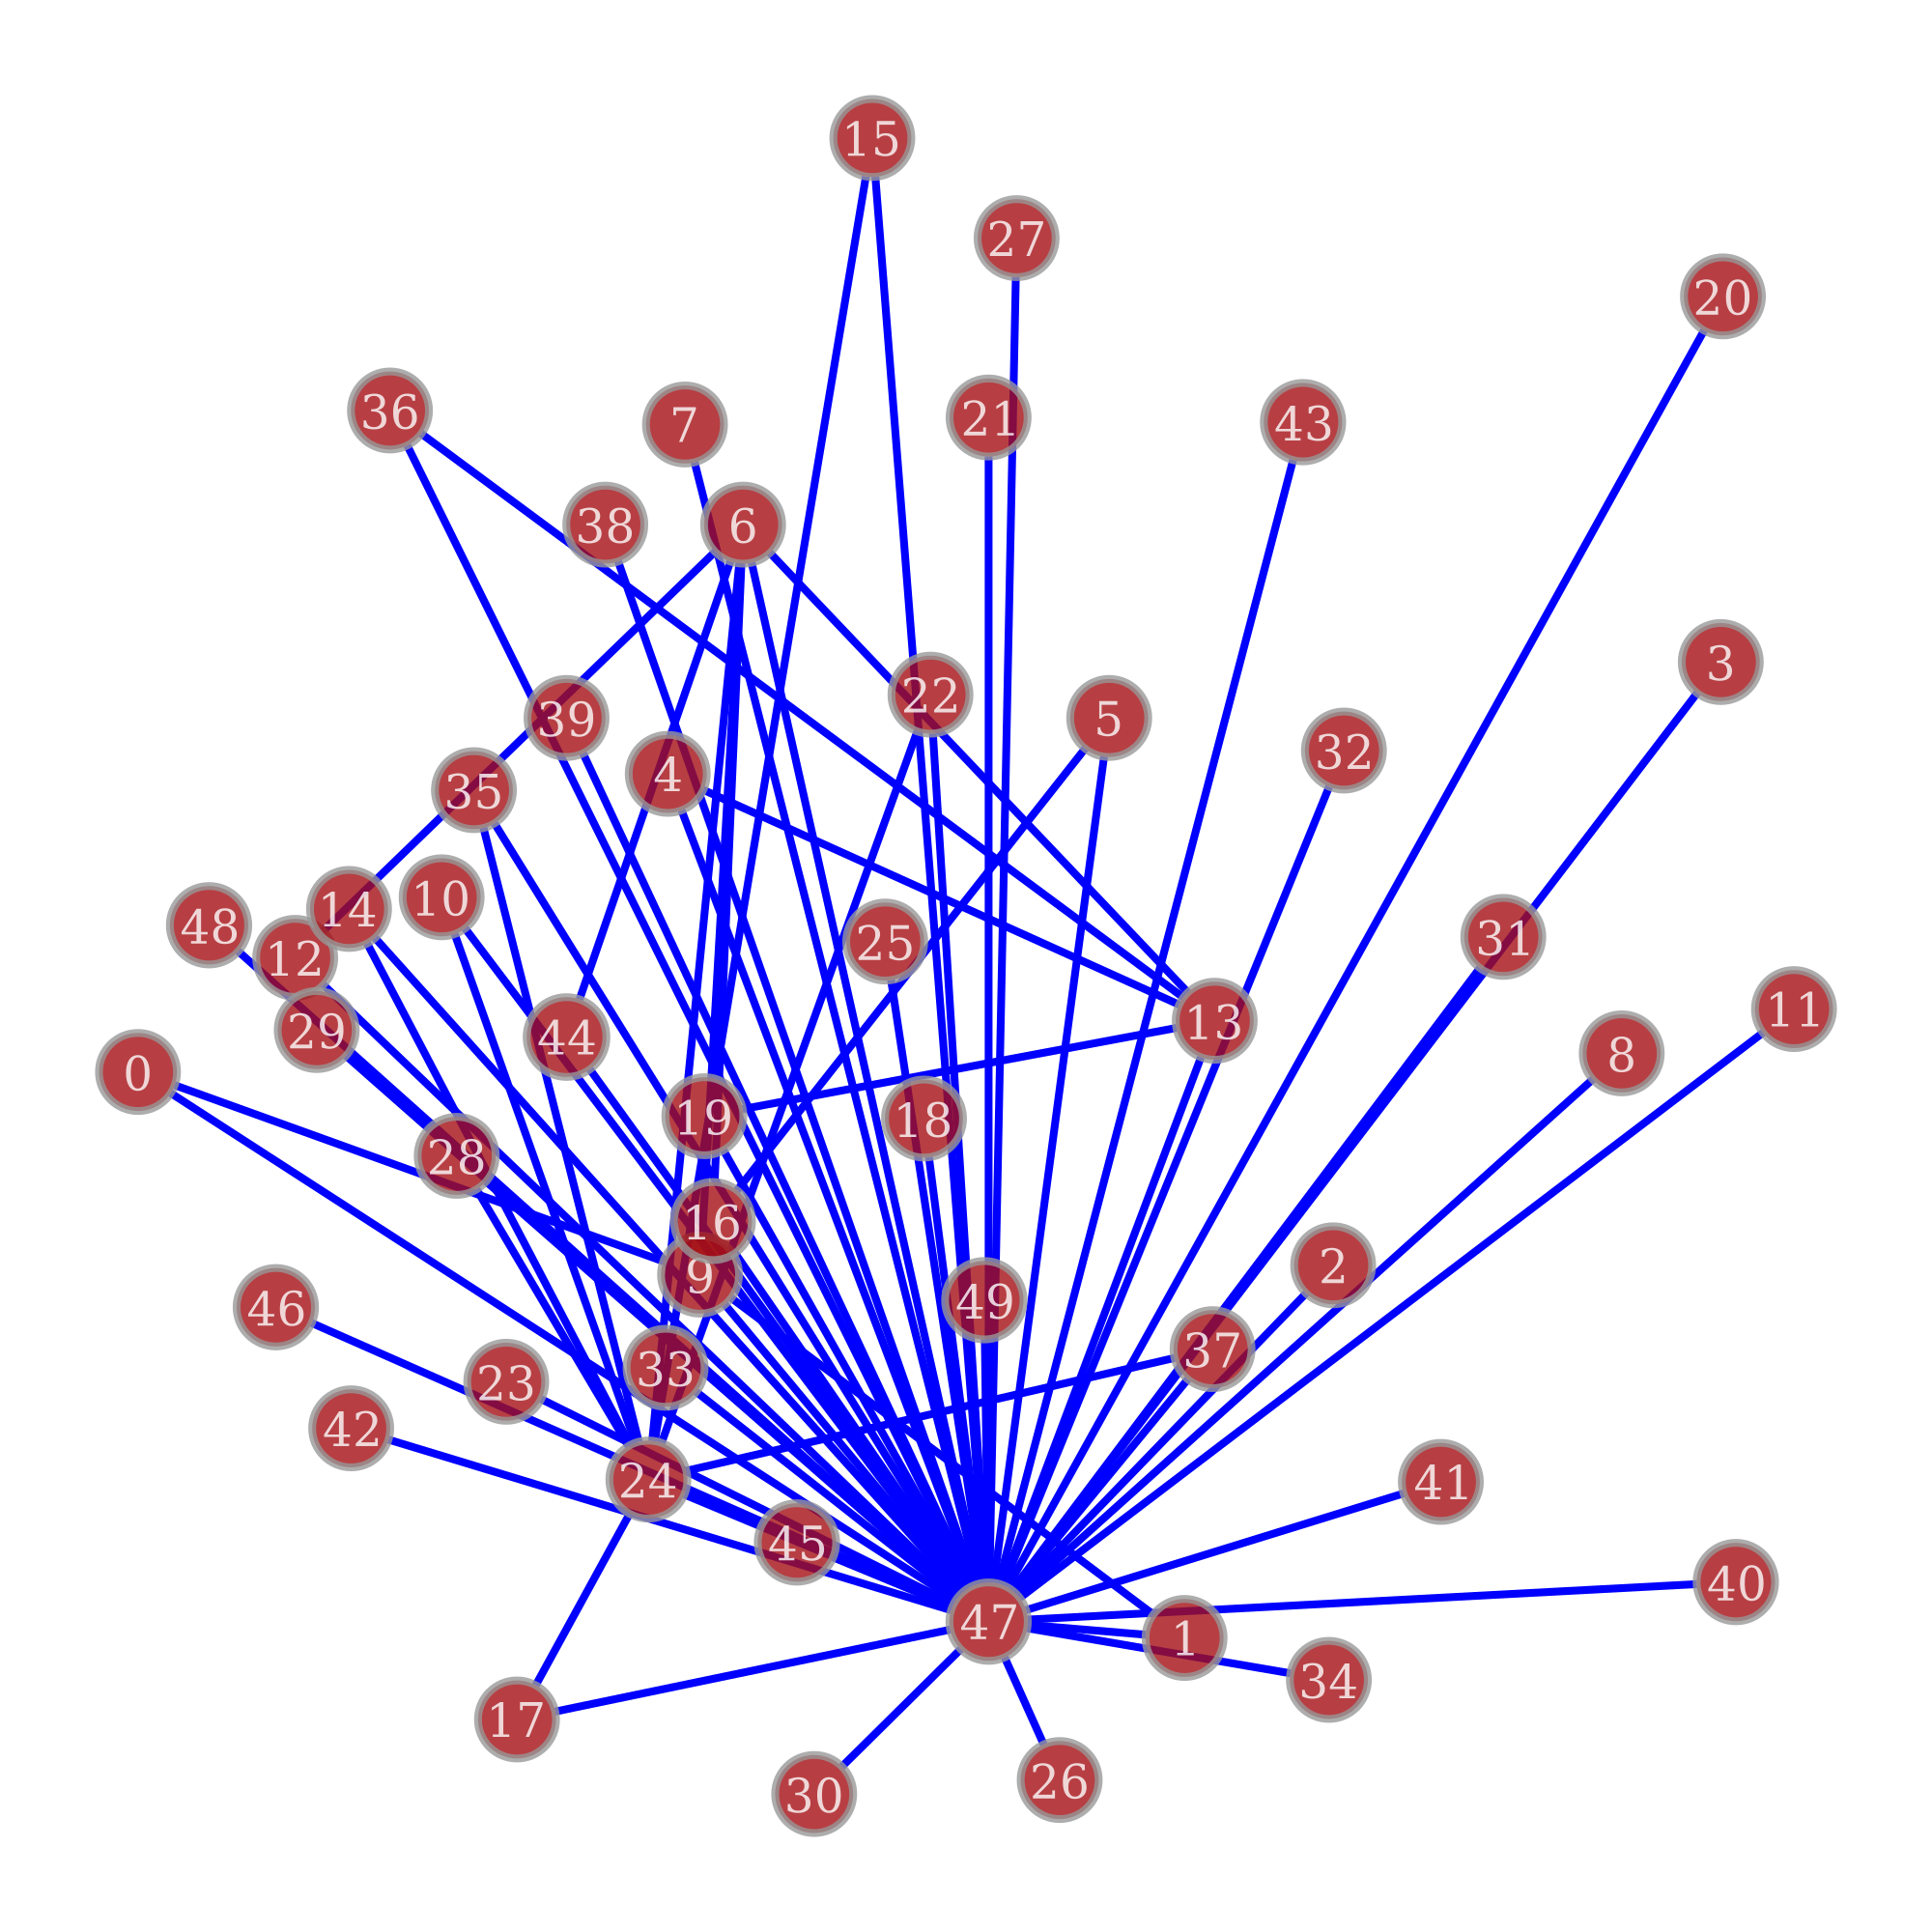

In [2]:
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import numpy as np
import random

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图　個体をグラフにデコードする
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                graph.add_edge(graph.vertex(i), graph.vertex(j))
    return graph

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69
        return float('inf'),  # 如果边数不为69，适应度设为无穷大
    dist_matrix = shortest_distance(graph).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))  # 图的维度
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]
    
    if edges and non_edges:
        # 移除一条边　1エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0
        
        # 添加一条边　1エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=500, stats=stats, halloffame=hof, verbose=True)
    return pop, stats, hof

if __name__ == "__main__":
    pop, stats, hof = main()
    best_individual = hof[0]
    best_graph = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))


In [32]:
print("nodes: ", best_graph.num_vertices(), "links ", best_graph.num_edges())

nodes:  50 links  69


nodes:  50 links  69
gen	nevals	min 
0  	300   	8838
1  	162   	8838
2  	202   	9186
3  	174   	9108
4  	182   	9144
5  	193   	9144
6  	193   	9138
7  	173   	9114
8  	160   	9050
9  	164   	9050
10 	184   	8976
11 	181   	8976
12 	171   	8974
13 	174   	8964
14 	180   	8816
15 	196   	8816
16 	161   	8816
17 	194   	8706
18 	172   	8706
19 	158   	8706
20 	166   	8706
21 	192   	8660
22 	161   	8572
23 	167   	8572
24 	171   	8552
25 	183   	8552
26 	171   	8538
27 	177   	8416
28 	197   	8416
29 	176   	8416
30 	184   	8376
31 	164   	8376
32 	177   	8304
33 	164   	8304
34 	187   	8276
35 	180   	8246
36 	182   	8240
37 	181   	8246
38 	192   	8234
39 	189   	8218
40 	178   	8200
41 	168   	8188
42 	163   	8166
43 	184   	8166
44 	170   	8126
45 	187   	8126
46 	194   	8110
47 	187   	8038
48 	181   	8038
49 	186   	8038
50 	196   	8022
51 	180   	8016
52 	180   	8016
53 	183   	7970
54 	197   	7942
55 	178   	7942
56 	192   	7872
57 	175   	7872
58 	181   	7872
59 	155   	7872
60 

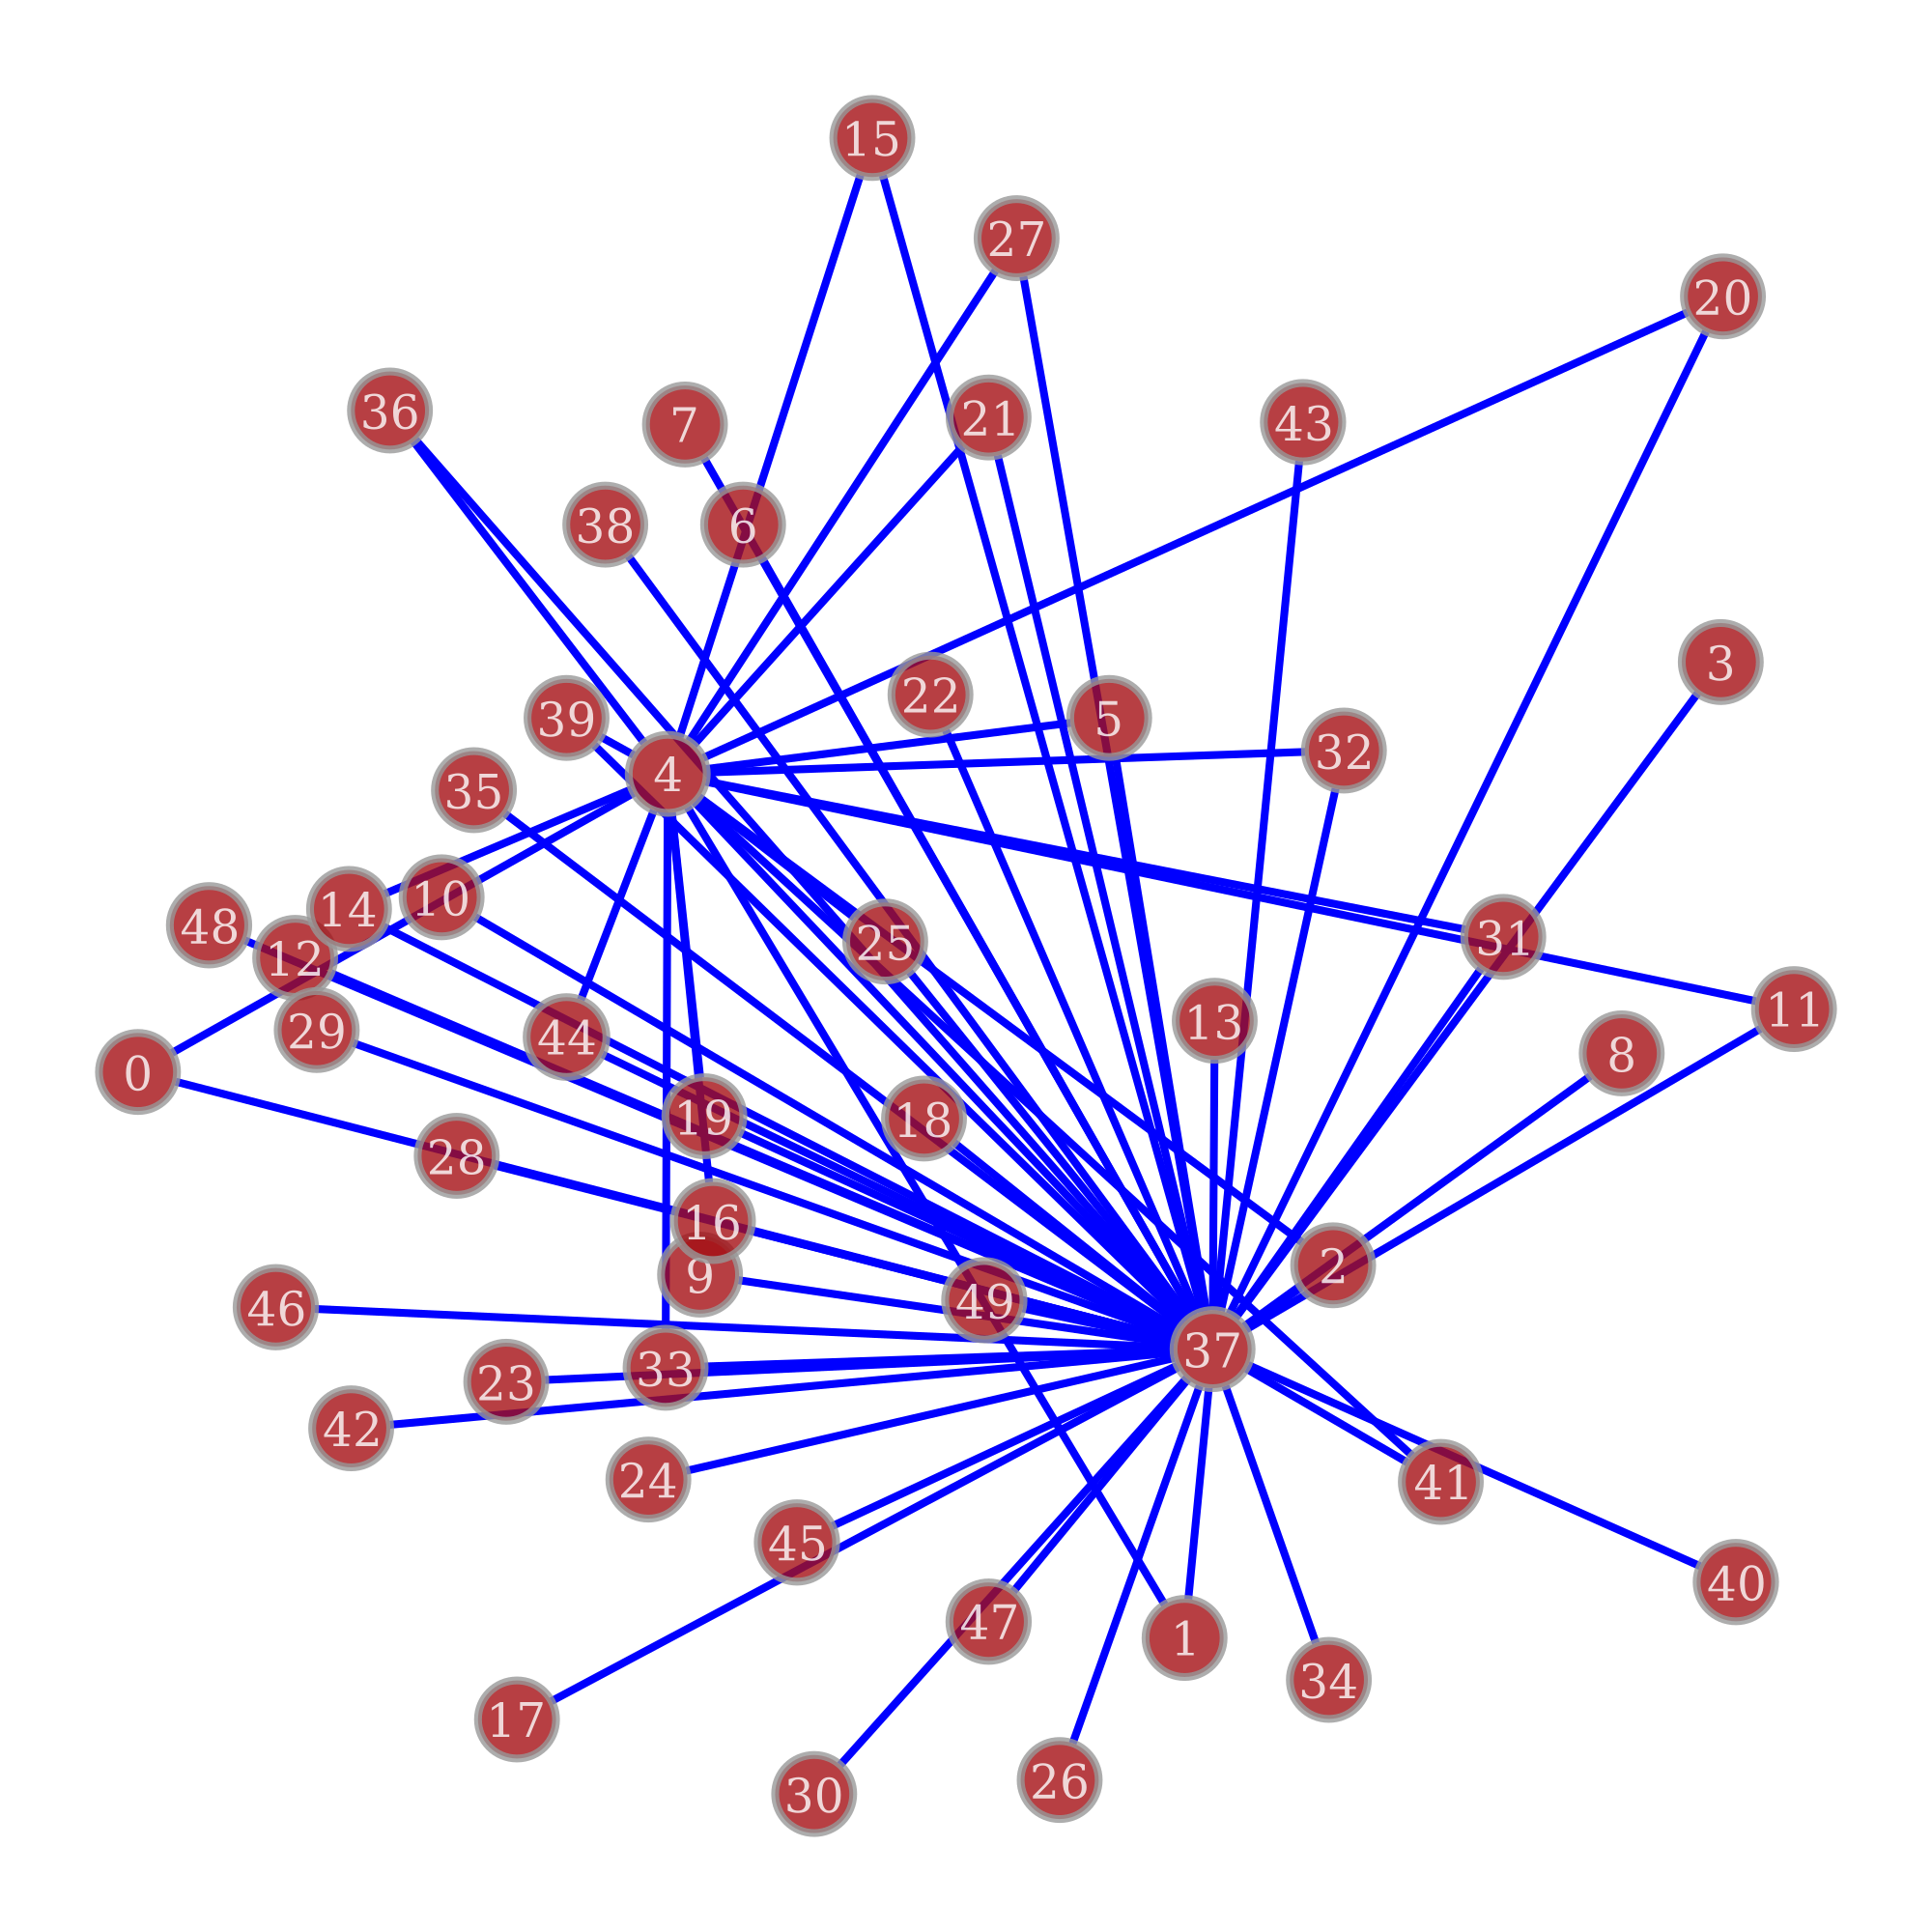

In [3]:
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import numpy as np
import random

# 读取图和位置信息　グラフと位置情報を読み取る
filename1 = "Germany50"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 将图转换为个体编码　グラフを個体エンコードに変換する
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图　個体をグラフにデコードする
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                graph.add_edge(graph.vertex(i), graph.vertex(j))
    return graph

# 定义适应度函数　適応度関数を定義する
def evaluate(individual):
    graph = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != 69:  # 边数限制，确保边数为69　エッジ数制限、エッジ数を69にする
        return float('inf'),  # 如果边数不为69，适应度设为无穷大　エッジ数が69でない場合、適応度を無限大に設定
    dist_matrix = shortest_distance(graph).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作　交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))
    return new_ind1, new_ind2

# 自定义变异操作　変異操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))  
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]
    
    if edges and non_edges:
        # 移除一条边　エッジを削除する
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0
        
        # 添加一条边　エッジを追加する
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置　遺伝的アルゴリズムの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数为69　初期個体を初期化する際にエッジ数を69に確保する
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    edges = random.sample([(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices)], 69)
    for i, j in edges:
        individual[i * num_vertices + j] = 1
        individual[j * num_vertices + i] = 1
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程　メイン遺伝的アルゴリズムフロー
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)


    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000, stats=stats, halloffame=hof, verbose=True)
    return pop, stats, hof

if __name__ == "__main__":
    pop, stats, hof = main()
    best_individual = hof[0]
    best_graph = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图　最終的に最適化されたグラフを描画する
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))


In [4]:
graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),output=f'./output_GA_deap/{filename1}.png')

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb572a10e00, at 0x7fb562ecc590>